In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
%pwd

'C:\\Users\\llaur\\OneDrive\\Desktop\\turb\\proj-turbulence'

In [9]:
%cd ../../../../Downloads/ERA_wind

C:\Users\llaur\Downloads\ERA_wind


In [10]:
fine = np.load("ERA_wind.npz")

# Load

## Train

In [11]:
%cd ../../OneDrive/Desktop/turb/proj-turbulence/train

C:\Users\llaur\OneDrive\Desktop\turb\proj-turbulence\train


In [12]:
# for lat in range(121)
#     for lon in range(201):
#         # the set of wind speeds at all time stamps at this one point
#         wind_speeds = [np.sqrt((u[i][1][lat][lon])**2 + (v[i][1][lat][lon])**2) for i in range (744)]

List comprehension of wind speeds at level 225

In [14]:
wind_v = fine["wind_v"][:744, 0, :120, :200]
wind_u = fine["wind_u"][:744, 0, :120, :200]

# wind_speeds = [[[np.sqrt((wind_u[i][1][lat][lon])**2 + (wind_v[i][1][lat][lon])**2) for lon in range(200)] for lat in range(120)] for i in range(744)]

wind_scalar = [np.sqrt(arr1**2 + arr2**2) for arr1, arr2 in zip(wind_v, wind_u)] # create array with wind scalar vales


In [15]:
len(wind_scalar), len(wind_scalar[0]), len(wind_scalar[0][0])

(744, 120, 200)

In [16]:
files = os.listdir(os.getcwd())

Add to coarse and fine lists in order

In [17]:
coarse_train = []
fine_train = []
for file in files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_train.append(np.load(file)) # load file, save into coarse
        fine_train.append(wind_scalar[int(timestamp)]) # load fine version

594 samples, # lat points, # lon points

In [18]:
len(coarse_train), len(coarse_train[0]), len(coarse_train[0][0])

(594, 15, 25)

In [19]:
len(fine_train), len(fine_train[0]), len(fine_train[0][0])

(594, 120, 200)

## Val

In [20]:
%cd ../val

C:\Users\llaur\OneDrive\Desktop\turb\proj-turbulence\val


In [21]:
files = os.listdir(os.getcwd())
coarse_val = []
fine_val = []
for file in files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_val.append(np.load(file)) # load file, save into coarse
        fine_val.append(wind_scalar[int(timestamp)]) # load fine version

In [22]:
len(coarse_val), len(coarse_val[0]), len(coarse_val[0][0])

(75, 15, 25)

In [23]:
len(fine_val), len(fine_val[0]), len(fine_val[0][0])

(75, 120, 200)

## Test

In [24]:
%cd ../test

C:\Users\llaur\OneDrive\Desktop\turb\proj-turbulence\test


In [25]:
files = os.listdir(os.getcwd())
coarse_test = []
fine_test = []
for file in files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_test.append(np.load(file)) # load file, save into coarse
        fine_test.append(wind_scalar[int(timestamp)]) # load fine version

In [26]:
len(coarse_test), len(coarse_test[0]), len(coarse_test[0][0])

(74, 15, 25)

In [27]:
len(fine_test), len(fine_test[0]), len(fine_test[0][0]), type(fine_test[0][0][0])

(74, 120, 200, numpy.float64)

## plot input data

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [29]:
lat = fine.get('lat')
lon = fine.get('lon')  
x_grid, y_grid = np.meshgrid(lon, lat, indexing='xy')
x_values = x_grid.flatten()
y_values = y_grid.flatten()

Text(0.5, 1.0, 'target')

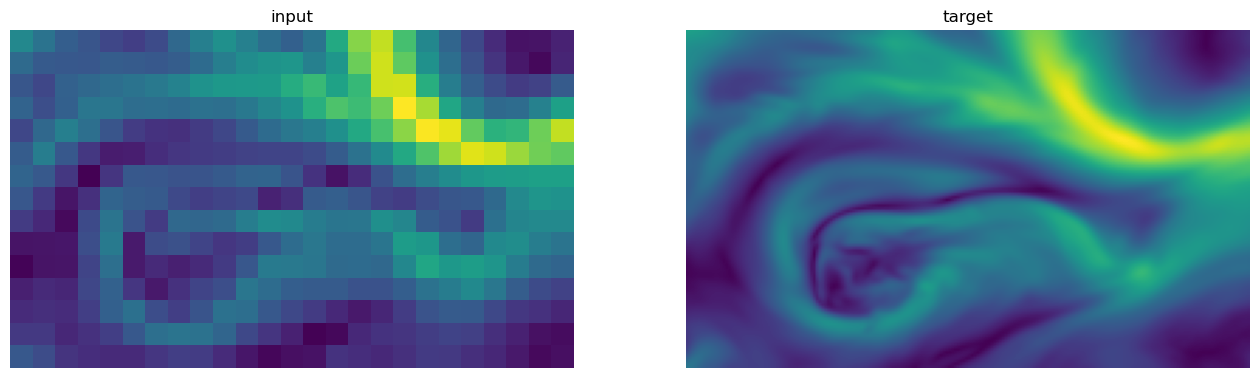

In [30]:
fig, axes = plt.subplots(1,2, figsize=(16,24))
axes[0].imshow(coarse_train[200])
axes[0].axis('off')
axes[0].set_title("input")
axes[1].imshow(fine_train[200])
axes[1].axis('off')
axes[1].set_title("target")

# CNN

In [31]:
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

## Load Data

In [32]:
class PairedImageDataset(Dataset):
    def __init__(self, coarse_images, high_res_images, transform=None):
        self.coarse_images = coarse_images
        self.high_res_images = high_res_images
        self.transform = transform

    def __len__(self):
        return len(self.coarse_images)

    def __getitem__(self, idx):
        coarse_img = self.coarse_images[idx]
        high_res_img = self.high_res_images[idx]

        if self.transform:
            coarse_img = self.transform(coarse_img)
            high_res_img = self.transform(high_res_img)

        return coarse_img, high_res_img

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train = PairedImageDataset(np.array(coarse_train), np.array(fine_train), transform=transform)
test = PairedImageDataset(np.array(coarse_test), np.array(fine_test), transform=transform)
val = PairedImageDataset(np.array(coarse_val), np.array(fine_val), transform=transform)

# load
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [33]:
np.array(coarse_train).shape, np.array(fine_train).shape

((594, 15, 25), (594, 120, 200))

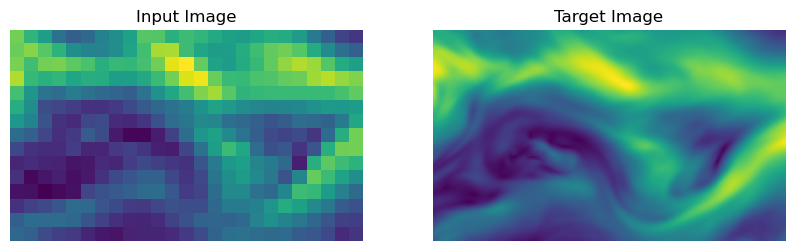

In [34]:
# Get one batch of samples from the training data
dataiter = iter(train_loader)
input_images, target_images = next(dataiter)

# Select one image from the batch
index = 0  # Choose the index of the image you want to plot
input_image = input_images[index]
target_image = target_images[index]

# Plot the input image and target image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image
axes[0].imshow(input_image.squeeze())
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the target image
axes[1].imshow(target_image.squeeze())
axes[1].set_title('Target Image')
axes[1].axis('off')

plt.show()

## Define CNN

In [48]:
class CNN(nn.Module):
    def __init__(self):
        upscale = 8
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, upscale**2, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.depth_to_space = nn.PixelShuffle(upscale)
        
    def forward(self, x):
        x = self.conv_layers(x.float())
        x = self.depth_to_space(x)
        return x
    
model = CNN()

## Train CNN

In [49]:
import torch

In [51]:
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
#         inputs = inputs.squeeze()
        targets = targets.squeeze() 
#         print("shapes ", inputs.shape, targets.shape)
        outputs = model(inputs)
        
        loss = criterion(outputs, targets.squeeze().float())
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.squeeze())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 1/500, Loss: 101.97627258300781, Val Loss: 105.55025994372501
Epoch 2/500, Loss: 100.20525360107422, Val Loss: 95.74113854998674
Epoch 3/500, Loss: 94.06272888183594, Val Loss: 102.14756154986908
Epoch 4/500, Loss: 122.21533203125, Val Loss: 114.16940110829066
Epoch 5/500, Loss: 98.27947235107422, Val Loss: 102.92167913770064
Epoch 6/500, Loss: 75.0857162475586, Val Loss: 98.08005998398413
Epoch 7/500, Loss: 106.0169677734375, Val Loss: 106.36207392689434
Epoch 8/500, Loss: 102.0108642578125, Val Loss: 93.30883524860623
Epoch 9/500, Loss: 120.46975708007812, Val Loss: 95.39716966630371
Epoch 10/500, Loss: 100.47357177734375, Val Loss: 97.78311978403649
Epoch 11/500, Loss: 127.08379364013672, Val Loss: 98.20200336985717
Epoch 12/500, Loss: 81.38706970214844, Val Loss: 105.47677801039
Epoch 13/500, Loss: 98.94791412353516, Val Loss: 110.41123085677847
Epoch 14/500, Loss: 123.6927490234375, Val Loss: 102.25265255693336
Epoch 15/500, Loss: 101.75430297851562, Val Loss: 104.0760061979

Epoch 122/500, Loss: 84.73714447021484, Val Loss: 110.252720672727
Epoch 123/500, Loss: 140.1602325439453, Val Loss: 101.20621738501607
Epoch 124/500, Loss: 107.91090393066406, Val Loss: 97.52190702492555
Epoch 125/500, Loss: 95.54688262939453, Val Loss: 87.4183180850408
Epoch 126/500, Loss: 123.3434829711914, Val Loss: 119.58298522129292
Epoch 127/500, Loss: 99.44241333007812, Val Loss: 101.78792155832221
Epoch 128/500, Loss: 102.67920684814453, Val Loss: 90.98833805380654
Epoch 129/500, Loss: 90.89542388916016, Val Loss: 99.10060411161913
Epoch 130/500, Loss: 92.80390930175781, Val Loss: 100.88612661953131
Epoch 131/500, Loss: 107.12979125976562, Val Loss: 99.62738324630706
Epoch 132/500, Loss: 116.06334686279297, Val Loss: 104.24498350193268
Epoch 133/500, Loss: 176.2500762939453, Val Loss: 97.54521055834904
Epoch 134/500, Loss: 86.43338775634766, Val Loss: 95.20932984651262
Epoch 135/500, Loss: 87.9542465209961, Val Loss: 98.15810467780356
Epoch 136/500, Loss: 100.48077392578125, V

Epoch 242/500, Loss: 97.63800811767578, Val Loss: 105.1659712097824
Epoch 243/500, Loss: 107.30939483642578, Val Loss: 96.04211170364854
Epoch 244/500, Loss: 134.85528564453125, Val Loss: 103.64614072007791
Epoch 245/500, Loss: 95.09188842773438, Val Loss: 101.40374552600267
Epoch 246/500, Loss: 154.5563507080078, Val Loss: 98.70955545554546
Epoch 247/500, Loss: 88.04374694824219, Val Loss: 99.81065772100752
Epoch 248/500, Loss: 108.272705078125, Val Loss: 91.26963938410279
Epoch 249/500, Loss: 87.7105484008789, Val Loss: 100.60207723895155
Epoch 250/500, Loss: 98.44161224365234, Val Loss: 104.14283740980171
Epoch 251/500, Loss: 186.47671508789062, Val Loss: 92.62403117398503
Epoch 252/500, Loss: 127.1016845703125, Val Loss: 97.34059575554187
Epoch 253/500, Loss: 96.19548034667969, Val Loss: 103.17276471038294
Epoch 254/500, Loss: 145.3514404296875, Val Loss: 97.61133716790255
Epoch 255/500, Loss: 108.66100311279297, Val Loss: 101.35293202907476
Epoch 256/500, Loss: 146.82789611816406,

Epoch 362/500, Loss: 142.85194396972656, Val Loss: 96.74991682467935
Epoch 363/500, Loss: 81.56023406982422, Val Loss: 93.47645210966817
Epoch 364/500, Loss: 89.13619995117188, Val Loss: 93.27518641529612
Epoch 365/500, Loss: 113.15476989746094, Val Loss: 99.54921794484272
Epoch 366/500, Loss: 169.35523986816406, Val Loss: 90.16079158596793
Epoch 367/500, Loss: 114.86422729492188, Val Loss: 110.32248155591428
Epoch 368/500, Loss: 80.30230712890625, Val Loss: 99.07022686237615
Epoch 369/500, Loss: 82.15885162353516, Val Loss: 100.99539274454101
Epoch 370/500, Loss: 104.19186401367188, Val Loss: 86.62542864478266
Epoch 371/500, Loss: 121.1708984375, Val Loss: 107.83586444540742
Epoch 372/500, Loss: 76.04952239990234, Val Loss: 88.34247285437286
Epoch 373/500, Loss: 93.00756072998047, Val Loss: 94.03802491421895
Epoch 374/500, Loss: 118.25904083251953, Val Loss: 99.74347696316343
Epoch 375/500, Loss: 117.9045181274414, Val Loss: 97.30256319278014
Epoch 376/500, Loss: 135.9239959716797, Va

Epoch 482/500, Loss: 101.0025634765625, Val Loss: 108.54126534078284
Epoch 483/500, Loss: 112.84278869628906, Val Loss: 95.55994376801074
Epoch 484/500, Loss: 101.4919662475586, Val Loss: 92.79945689995748
Epoch 485/500, Loss: 78.14895629882812, Val Loss: 98.50410105594509
Epoch 486/500, Loss: 95.30207061767578, Val Loss: 91.73939278721109
Epoch 487/500, Loss: 112.14555358886719, Val Loss: 92.98093233028999
Epoch 488/500, Loss: 143.60496520996094, Val Loss: 102.43268905680263
Epoch 489/500, Loss: 117.6794662475586, Val Loss: 100.51977078321663
Epoch 490/500, Loss: 90.8094253540039, Val Loss: 106.69655978317444
Epoch 491/500, Loss: 89.02435302734375, Val Loss: 98.89489063112985
Epoch 492/500, Loss: 81.03568267822266, Val Loss: 96.49100261342542
Epoch 493/500, Loss: 119.75453186035156, Val Loss: 96.06256459346638
Epoch 494/500, Loss: 113.23020935058594, Val Loss: 102.20649199302225
Epoch 495/500, Loss: 142.89747619628906, Val Loss: 95.12205748182404
Epoch 496/500, Loss: 82.45372772216797

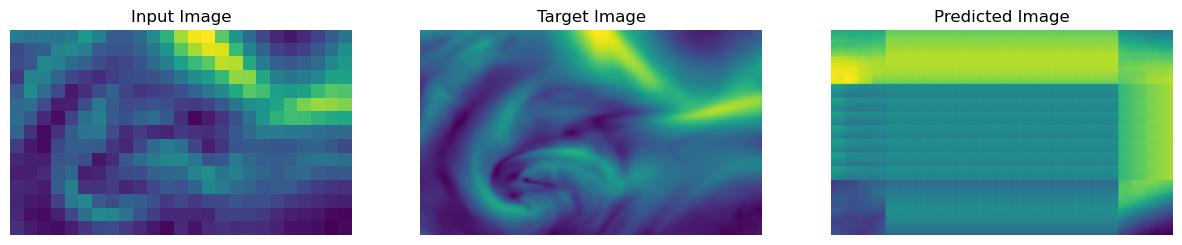

In [52]:
# Get one batch of samples from the training data
dataiter = iter(test_loader)
input_images, target_images = next(dataiter)

# Select one image from the batch
index = 0  # Choose the index of the image you want to plot
input_image = input_images[index]
target_image = target_images[index]

# Make prediction using the CNN model
with torch.no_grad():
    predicted_image = model(input_image.unsqueeze(0))  # Add an extra dimension for batch

# Plot the input image, target image, and predicted image side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input image
axes[0].imshow(input_image.squeeze())
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the target image
axes[1].imshow(target_image.squeeze())
axes[1].set_title('Target Image')
axes[1].axis('off')

# Plot the predicted image
axes[2].imshow(predicted_image.squeeze().cpu().numpy())
axes[2].set_title('Predicted Image')
axes[2].axis('off')

plt.show()
